In [6]:
import requests
import json
import pandas as pd

## Autenticación

Realizamos la autenticación con token de usuario previamente extraido de la configuración de Falabella

In [9]:
secret_key = "04c6bde64292ccabefbd4bda6cb607f0"#AQUI-SECRET-TOKEN 

In [10]:
query = """mutation SignIn {
  signIn(input:{
    secretKey:"%s",
    clientMutationId:""
  }) {
    jwt
    errors
    code
  }
}""" % secret_key

In [4]:
url = "https://performance-reports-api.rankmi.com/authentication/sign_in"

In [11]:
r = requests.post(url, json={'query':query})

if r.status_code != 200:
    raise ValueError("Error inesperado de Autenticacion: {}".format(r.text))

json_data = json.loads(r.text)
jwt = json_data["data"]["signIn"]["jwt"] if 'data' in json_data and 'signIn' in json_data['data'] else None
    
if jwt is None:
    raise ValueError("Error de Autenticacion: {}".format(json_data["data"]["signIn"]["errors"]))

headers = { "Authorization" : jwt }

## Proceso: Evaluación Ejecutiva 2020

In [12]:
process = "AQUI-TOKEN-PROCESO"
process_id = "AQUI-ID-PROCESO"

In [13]:
query_process = """query {
     enterpriseProcesses {
         id
         token
         name
         description
         status
         startDate
         dueDate
   }
}"""

In [14]:
url_process = "https://performance-reports-api.rankmi.com/enterprise-processes"

In [27]:
rprocess = requests.post(url_process, json={'query':query_process}, headers=headers)

if rprocess.status_code != 200:
    raise ValueError("Error inesperado de Consulta de Procesos:", rprocess.text)

json_process = json.loads(rprocess.text)

enterpriseProcesses = json_process['data']['enterpriseProcesses'] if 'data' in json_process and 'enterpriseProcesses' in json_process['data'] else None

if enterpriseProcesses is None:
    raise ValueError("Error de Consulta Procesos: {}".format(json_collab['errors'][0]['message']))
    
process, process_name = None, None
for p in enterpriseProcesses:
    if p["id"] == process_id:
        process = p["token"]
        process_name = p["name"]
        
if process is None:
    raise ValueError("Error Proceso No Encontrado: {}".format(process_id))

## Colaboradores del Proceso

Aqui consultaremos a los colaboradores que estan incluidos proceso de desempeño elegido previamente

In [28]:
query_collaborators = """query {
  collaboratorsList(processToken: "%s"
  page: 3
  lang: "en"){
     id
     rut
     name
     token
     email
  }
}""" % process

In [17]:
url_collab = "https://performance-reports-api.rankmi.com/collaborators/index"

In [18]:
rcollab = requests.post(url_collab, json={'query':query_collaborators}, headers=headers)

if rcollab.status_code != 200:
    raise ValueError("Error inesperado de Consulta Colaboradores:", rcollab.text)

json_collab = json.loads(rcollab.text)

collaboratorsList = json_collab['data']['collaboratorsList'] if 'data' in json_collab and 'collaboratorsList' in json_collab['data'] else None

if collaboratorsList is None:
    raise ValueError("Error de Consulta Colaboradores: {}".format(json_collab['errors'][0]['message']))


## Resultados Individuales de colaboradores

Ahora con el listado de colaboradores, iteraremos para extraer toda la información de resultados individuales y con esta información armar el dataframe con el resumen de la información requerida. Para realizar las pruebas de un ejercicio, tomaremos solo un numero limitado de registros (N_COLLABORATORS) y construiremos la data conforme el requerimiento de Falabella para este proceso. 

In [19]:
url_individual_res = "https://performance-reports-api.rankmi.com/individual-results"

def consulta_individual_colaborador(proceso, colaborador):
    query_ind_result = """query {
      individualResult(processToken: "%s"
      collaboratorToken: "%s"
      lang: "en"){
         id
         name
         token
         area
         position
         email
         evaluators
         generalAverage{
          evaluationDomain
          evaluationResult
        }
        domains{
          domainId
          name
          domainAverage
          competencesAverage
          goalsAverage
          competences
          categoriesConducts
        }
      }
    }""" % (proceso, colaborador)
    
    rindividual = requests.post(url_individual_res, json={'query':query_ind_result}, headers=headers)
    
    if rindividual.status_code != 200:
        raise ValueError("Error inesperado de Consulta Colaboradores:", rindividual.text)

    json_individ = json.loads(rindividual.text)

    individualResult = json_individ['data']['individualResult'] if 'data' in json_individ and 'individualResult' in json_individ['data'] else None

    if individualResult is None:
        raise ValueError("Error de Consulta Individual: {}".format(json_individ['errors'][0]['message']))
        
    return individualResult  

In [21]:
N_COLLABORATORS = 5

In [29]:
CATEGORY = {
    'Parcial fulfils':'Cumple Satisfactorio',
    'Satisfactory fulfils':'Sobresaliente',
    'Under expected':'Bajo lo esperado',
    'Outstanding':'Pendiente'
}

def get_competence(domain):
    if 'competencesAverage' in domain:
        competencesAverage = domain['competencesAverage']
        qualification = competencesAverage['average']
        return {
            'qualification':qualification,
            'category':CATEGORY[competencesAverage['label']],
            'group':'Grupo por definir',
            'competence':'Competencia por definir'
        }
        
    return None

def get_domain_performance(r_ind):
    domains = r_ind['domains'] if 'domains' in r_ind else None
    if domains and len(domains) > 0:
        for d in domains:
            if 'name' in d and d['name'] == 'Performance':
                competence = get_competence(d)
                return  {
                    'domain':"Desempeño",
                    'group':competence['group'],
                    'competence':competence['competence'],
                    'qualification':competence['qualification'],
                    'category': competence['category']
                }
    
    return None

In [30]:
indiv_data_collaborators = []

for i in range(0,N_COLLABORATORS):
    try:
        collaborator = collaboratorsList[i]
        r_ind = consulta_individual_colaborador(process, collaborator["token"])
        domain = get_domain_performance(r_ind)
        
        indiv_data_collaborators.append({
            'ID Proceso':process_id,
            'Nombre Proceso':process_name,
            'Identifier Colaborador':collaborator["rut"],
            'Nombre Colaborador':collaborator["name"],
            'Correo Colaborador':collaborator["email"],
            'Cargo Colaborador':r_ind["position"],
            'Familia de Cargo':r_ind["position_family"] if "position_family" in r_ind else "---",
            'Genero Colaborador':r_ind["gender"] if "gender" in r_ind else "---",
            'Fecha de Nacimiento':r_ind["born_date"] if "born_date" in r_ind else "---",
            'Ingreso Cargo':r_ind["position_input"] if "position_input" in r_ind else "---",
            'Dominio':domain["domain"] if domain else "---",
            'Grupo Competencias':domain["group"] if domain else "---",
            'Competencia':domain["competence"] if domain else "---",
            'Nota':domain["qualification"] if domain else "---",
            'Categoria':domain["category"] if domain else "---"
        })
    except Exception as e:
        print(e)

In [31]:
collaborators_df = pd.DataFrame(indiv_data_collaborators)
collaborators_df

,ID Proceso,Nombre Proceso,Identifier Colaborador,Nombre Colaborador,Correo Colaborador,Cargo Colaborador,Familia de Cargo,Genero Colaborador,Fecha de Nacimiento,Ingreso Cargo,Dominio,Grupo Competencias,Competencia,Nota,Categoria
0,4876,Evaluación Ejecutiva 2020,25750521-9,Pablo Balbis .,pbalbis@falabella.cl,GERENTE,---,---,---,---,Desempeño,Grupo por definir,Competencia por definir,2.64,Cumple Satisfactorio
1,4876,Evaluación Ejecutiva 2020,11490964-5,Juan Carlos Seaman Ramirez,jcseaman@falabella.cl,Arquitecto de Integraciones,---,---,---,---,Desempeño,Grupo por definir,Competencia por definir,2.96,Sobresaliente
2,4876,Evaluación Ejecutiva 2020,13062613,Jose Leonardo Talloni Tirado,jltalloni@falabella.cl,Subgerente de Soporte,---,---,---,---,Desempeño,Grupo por definir,Competencia por definir,3.40,Pendiente
3,4876,Evaluación Ejecutiva 2020,15219075-1,Juan Pablo Zapata Segura,jpzapatas@falabella.cl,Subgerente Core,---,---,---,---,Desempeño,Grupo por definir,Competencia por definir,3.17,Sobresaliente
4,4876,Evaluación Ejecutiva 2020,16001533-0,Renato Martin Covarrubias Romero,rmcovarrubias@falabella.cl,Subgerente Corp Devops & Cloud,---,---,---,---,Desempeño,Grupo por definir,Competencia por definir,3.46,Pendiente


<AxesSubplot:xlabel='Categoria'>

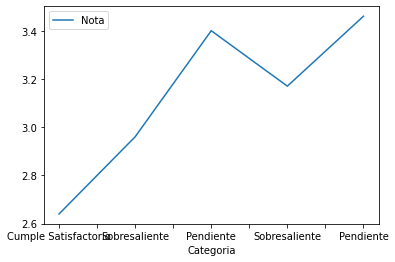

In [32]:
import matplotlib.pyplot as plt
collaborators_df.plot(y="Nota",x="Categoria")